### 1.0整体可以分为两部分：提取特征；分类

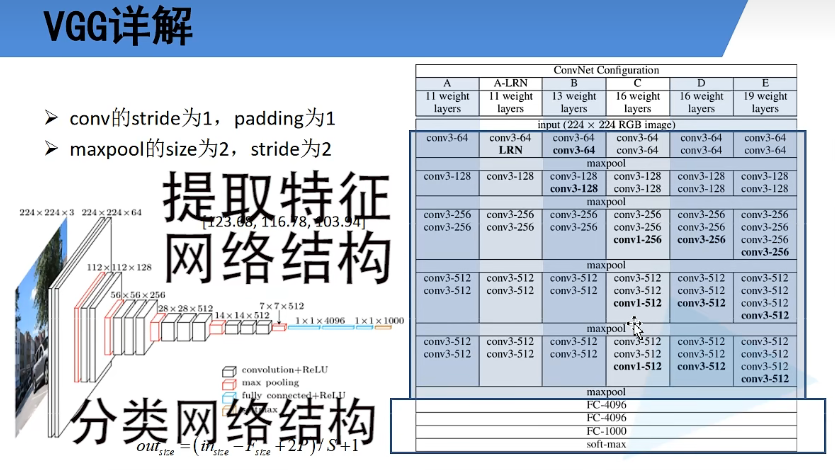

In [1]:
import torch.nn as nn
import torch

D:\ProgramData\Anaconda3\envs\study\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# official pretrain weights
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
}

### 1.1VGG网络不同模型的配置参数

In [3]:
# 不同模型对应不同的配置（其中数字代表卷积核的个数，M代表Maxpooling）
cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

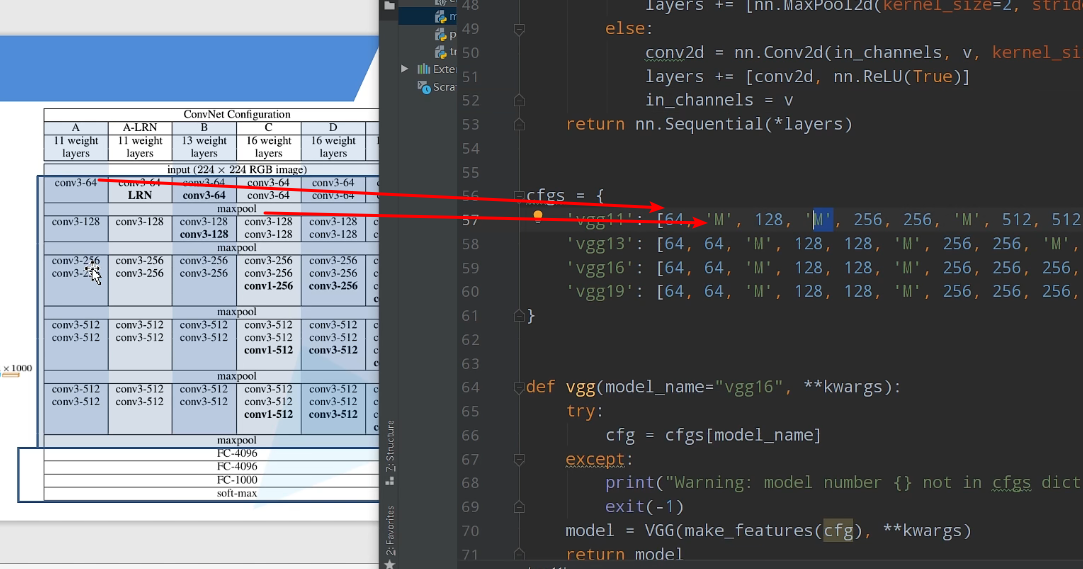

### 1.2创建VGG网络模型

In [5]:
# 创建vgg网络模型
def vgg(model_name="vgg16", **kwargs):      # **kwargs代表长度可变的字典参数
    # assert关键字，如果条件model_name in cfgs不为true，则引发引发AssertionError，打印出后面的信息
    assert model_name in cfgs, "Warning: model number {} not in cfgs dict!".format(model_name)
    cfg = cfgs[model_name]  # 默认model_name为vgg16

    model = VGG(make_features(cfg), **kwargs)   # 实例化对应网络
    return model

解释一下非关键字参数（It is used to pass a non-key worded, variable-length argument list）

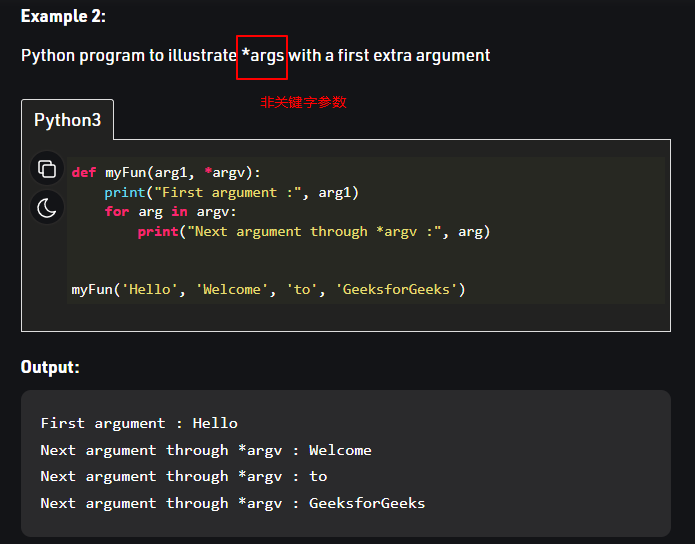

解释一下关键字参数(It is used to pass a keyworded, variable-length argument list)

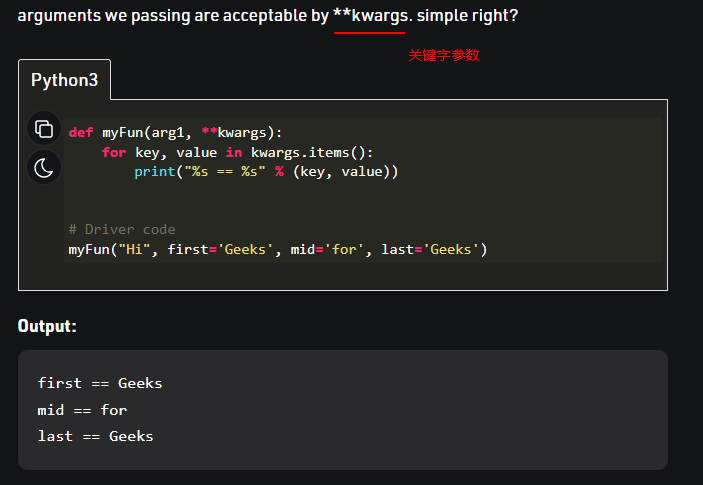

### 1.3创建vgg网络模型中的特征提取结构

In [6]:
# 创建vgg网络模型中的特征提取结构
def make_features(cfg: list):
    layers = []  # 存放网络结构各层
    in_channels = 3  # 输入
    for v in cfg:
        if v == "M":  # 如果是字母M，该层是Maxpooling层
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]  # 则添加池化层
        else:  # 如果该层是数字，也就是卷积层
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)  # 此处v是out_channels
            layers += [conv2d, nn.ReLU(True)]  # 则添加卷积层，并随后添加ReLU激活函数
            in_channels = v  # 重置in_channels
    return nn.Sequential(*layers)  # 把layers作为非关键字参数传入Sequential（参数前面带有*表示是非关键字参数）

两种构建网络模型的方式，第一种就是使用非关键字参数来构建；而第二种是使用关键字参数（即字典，有key值的那个数据结构）来构建

下图是进入源码查看得到的

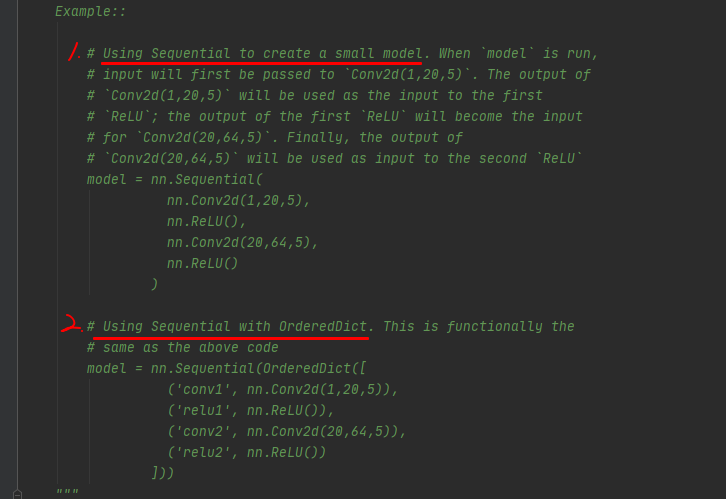

### 1.4 VGG类继承Module类，___init__初始化，forward正向传播，_initialize_weights初始化权重

In [7]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        # 提取图像特征网络结构
        # 我的理解，VGG是自己定义的网络模型，继承了父类nn.Module类，有两个属性，分别是features和classifier
        self.features = features  # features是传入的
        # 图像分类网络结构
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 2048),  # 原论文是4096，这里为了减少训练参数，设置为2048
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),  # 全连接层1和全连接层2之间添加dropout
            nn.Linear(2048, num_classes)  # 输出层，num_classes分类类别个数
        )
        if init_weights:  # 如果init_weights为true，则调用初始化参数权重函数
            self._initialize_weights()

    # 定义正向传播过程
    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.features(x)  # 提取特征网络结构
        # N x 512 x 7 x 7
        x = torch.flatten(x, start_dim=1)  # 将x进行展平处理，这样就好解释了（因为第0个维度是batch，所以dim要为1，展平）
        # N x 512*7*7
        x = self.classifier(x)  # 分类网络结构
        return x

    # 初始化权重
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):  # 如果当前层是卷积层，则使用xavier_uniform_方法初始化
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:  # 如果偏置不为None，则初始化为0
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):  # 如果当前层是全连接层，则同样使用xavier_uniform_初始化全连接层权重
                nn.init.xavier_uniform_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)  # 将偏置初始化为0